In [1]:
# Install necessary packages
!pip install kaggle lightgbm wordcloud numpy pandas matplotlib seaborn scikit-learn nltk accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
# Kaggle setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# Download dataset
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 80% 65.0M/80.9M [00:02<00:00, 32.7MB/s]
100% 80.9M/80.9M [00:02<00:00, 39.3MB/s]


In [4]:
from zipfile import ZipFile
df ='/content/sentiment140.zip'

with ZipFile(df,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pickle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import warnings
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV
norm_target=0                                       #Normalize target switch
norm_features=0                                     #Normalize target switch
binning=1                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=1                                       #Control Switch for Feature Selection
fs_type=2                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=5                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3

#Set global model parameters
rand_st=1

Data Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None
   target         ids                          date      flag           user  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                               

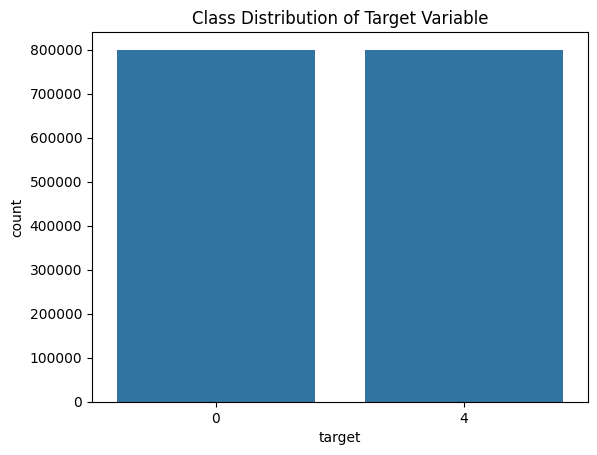

Number of duplicate entries: 0
Descriptive statistics for numerical features:
              target           ids
count  1.599999e+06  1.599999e+06
mean   2.000001e+00  1.998818e+09
std    2.000001e+00  1.935757e+08
min    0.000000e+00  1.467811e+09
25%    0.000000e+00  1.956916e+09
50%    4.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09
Unique values in the 'flag' column:
 ['NO_QUERY']
Class distribution in the dataset:
 target
4    50.000031
0    49.999969
Name: proportion, dtype: float64


In [8]:
# Load data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

df.shape

# Display basic info and the first few rows
print(df.info())
print(df.head())

# Check for missing data
missing_data = df.isnull().sum()
print("Missing data in each column:\n", missing_data)

# Proportion of missing data relative to the total dataset
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("Percentage of missing data:\n", missing_percentage)

# Check the balance of the classes in the target variable
sns.countplot(x='target', data=df)
plt.title('Class Distribution of Target Variable')
plt.show()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate entries:", duplicates)

# Remove duplicates if necessary
df = df.drop_duplicates()

# Descriptive statistics for numerical features
print("Descriptive statistics for numerical features:\n", df.describe())

# Check unique values for categorical data to find irregularities
print("Unique values in the 'flag' column:\n", df['flag'].unique())

# Display percentage of each class
class_balance = df['target'].value_counts(normalize=True) * 100
print("Class distribution in the dataset:\n", class_balance)


Data Preprocessing

In [10]:
# Data Preprocessing
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [porter_stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['stemmed_content'] = df['text'].apply(preprocess_text)
df['sentiment'] = df['target'].replace({0: 0, 4: 1})  # Convert to binary classes 0 (Negative) and 1 (Positive)


Sentiment Distribution Plot

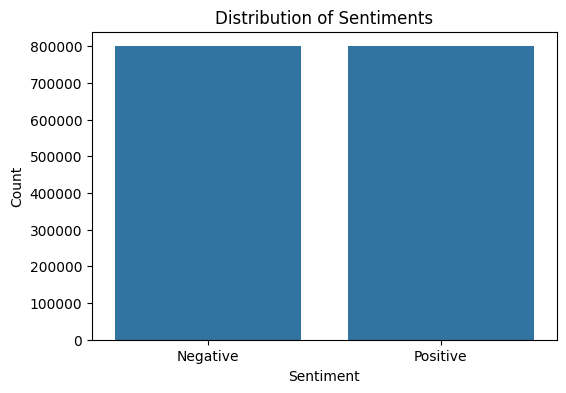

In [11]:
# Sentiment Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


 Word Cloud for Positive and Negative Tweets

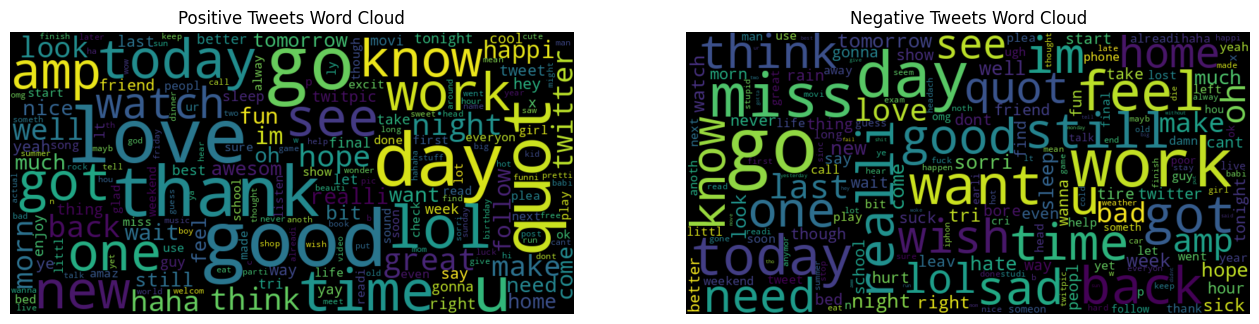

In [12]:
# Generate Word Cloud for Positive and Negative Tweets
positive_tweets = df[df['sentiment'] == 1]['stemmed_content']
negative_tweets = df[df['sentiment'] == 0]['stemmed_content']

positive_text = ' '.join(positive_tweets)
negative_text = ' '.join(negative_tweets)

wordcloud_positive = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(negative_text)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis('off')

plt.show()


Tweet Length Distribution

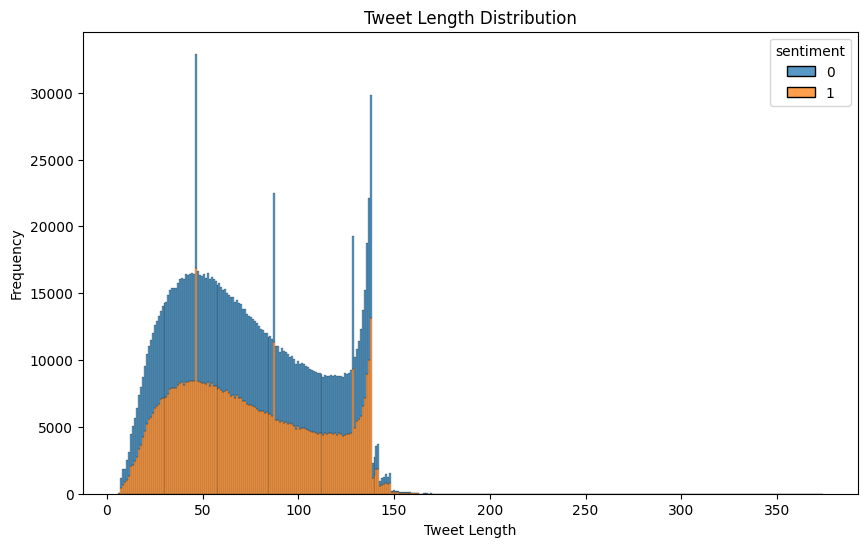

In [13]:
# Calculate tweet lengths
df['tweet_length'] = df['text'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_length', hue='sentiment', multiple='stack')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


Feature Engeneering & training

In [14]:
# Prepare data for model
X = df['stemmed_content'].values
Y = df['sentiment'].values

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [15]:
# Define cross-validation scorers
cross_val = 1
scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

def evaluate_model(clf, X_train, Y_train):
    start_ts = time.time()
    scores = cross_validate(clf, X_train, Y_train, scoring=scorers, cv=5, n_jobs=-1)
    print(f"{clf.__class__.__name__} Acc: %0.2f (+/- %0.2f)" % (scores['test_Accuracy'].mean(), scores['test_Accuracy'].std() * 2))
    print(f"{clf.__class__.__name__} AUC: %0.2f (+/- %0.2f)" % (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2))
    print("CV Runtime:", time.time() - start_ts)


In [17]:
# Initialize and evaluate Logistic Regression
import time
lr_model = LogisticRegression(max_iter=1000, random_state=1)
evaluate_model(lr_model, X_train_vec, Y_train)

# Final evaluation on test set
lr_model.fit(X_train_vec, Y_train)
Y_pred = lr_model.predict(X_test_vec)

# Convert string labels to integers
encoder = LabelEncoder()
Y_test_encoded = encoder.fit_transform(Y_test)
Y_pred_encoded = encoder.transform(Y_pred)

# Calculate the AUC
print('Logistic Regression Test Accuracy:', accuracy_score(Y_test_encoded, Y_pred_encoded))
print('Logistic Regression Test AUC:', roc_auc_score(Y_test_encoded, Y_pred_encoded))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


LogisticRegression Acc: 0.77 (+/- 0.00)
LogisticRegression AUC: 0.85 (+/- 0.00)
CV Runtime: 89.57956004142761
Logistic Regression Test Accuracy: 0.768378125
Logistic Regression Test AUC: 0.768378125


In [18]:
cm = confusion_matrix(Y_test_encoded, Y_pred_encoded)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[119243  40757]
 [ 33362 126638]]


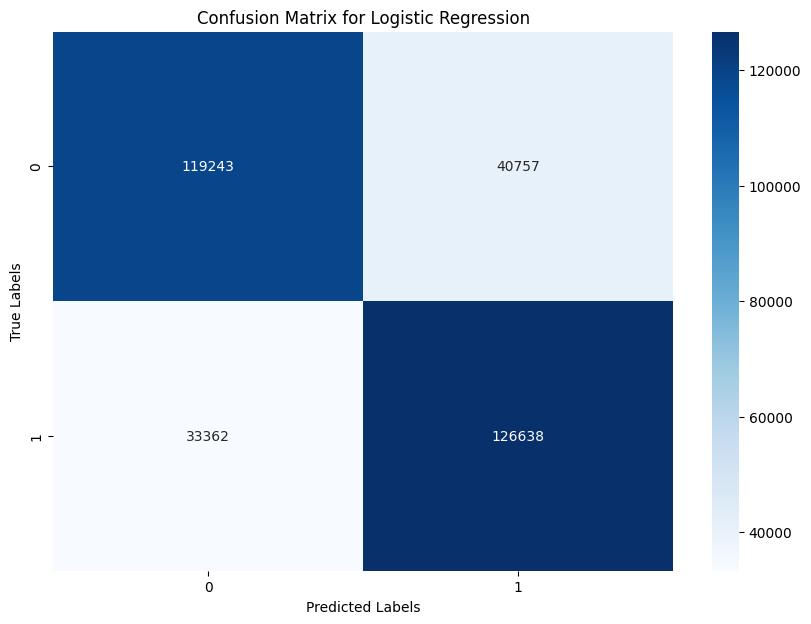

In [19]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [20]:
# Define the LightGBM model
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=1)
evaluate_model(lgb_model, X_train_vec, Y_train)

# Final evaluation on test set
lgb_model.fit(X_train_vec, Y_train)
Y_pred_lgb = lgb_model.predict(X_test_vec)

# if it's not already numerical
Y_pred_lgb_encoded = encoder.transform(Y_pred_lgb)

# Now calculate the AUC for LightGBM
print('LightGBM Test Accuracy:', accuracy_score(Y_test_encoded, Y_pred_lgb_encoded))
print('LightGBM Test AUC:', roc_auc_score(Y_test_encoded, Y_pred_lgb_encoded))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


LGBMClassifier Acc: 0.72 (+/- 0.00)
LGBMClassifier AUC: 0.80 (+/- 0.00)
CV Runtime: 1209.949098110199
[LightGBM] [Info] Number of positive: 640000, number of negative: 639999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 129.728860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256378
[LightGBM] [Info] Number of data points in the train set: 1279999, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000002
[LightGBM] [Info] Start training from score 0.000002
LightGBM Test Accuracy: 0.724590625
LightGBM Test AUC: 0.7245906249999999


In [21]:
# Define and evaluate Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=3, min_samples_leaf=1, random_state=1)
evaluate_model(dt_model, X_train_vec, Y_train)

# Final evaluation on test set
dt_model.fit(X_train_vec, Y_train)
Y_pred_dt = dt_model.predict(X_test_vec)

# Encode predictions if necessary
Y_pred_dt_encoded = encoder.transform(Y_pred_dt)

# Calculate the AUC for Decision Tree
print('Decision Tree Test Accuracy:', accuracy_score(Y_test_encoded, Y_pred_dt_encoded))
print('Decision Tree Test AUC:', roc_auc_score(Y_test_encoded, Y_pred_dt_encoded))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


DecisionTreeClassifier Acc: 0.59 (+/- 0.00)
DecisionTreeClassifier AUC: 0.64 (+/- 0.00)
CV Runtime: 98.93450260162354
Decision Tree Test Accuracy: 0.59090625
Decision Tree Test AUC: 0.59090625


In [22]:
# Define and evaluate Naive Bayes model
nb_model = MultinomialNB()
evaluate_model(nb_model, X_train_vec, Y_train)

# Final evaluation on test set
nb_model.fit(X_train_vec, Y_train)
Y_pred_nb = nb_model.predict(X_test_vec)

# Encode predictions if necessary
Y_pred_nb_encoded = encoder.transform(Y_pred_nb)

# Calculate the AUC for Naive Bayes
print('Naive Bayes Test Accuracy:', accuracy_score(Y_test_encoded, Y_pred_nb_encoded))
print('Naive Bayes Test AUC:', roc_auc_score(Y_test_encoded, Y_pred_nb_encoded))


MultinomialNB Acc: 0.75 (+/- 0.00)
MultinomialNB AUC: 0.83 (+/- 0.00)
CV Runtime: 2.8923609256744385
Naive Bayes Test Accuracy: 0.753296875
Naive Bayes Test AUC: 0.753296875


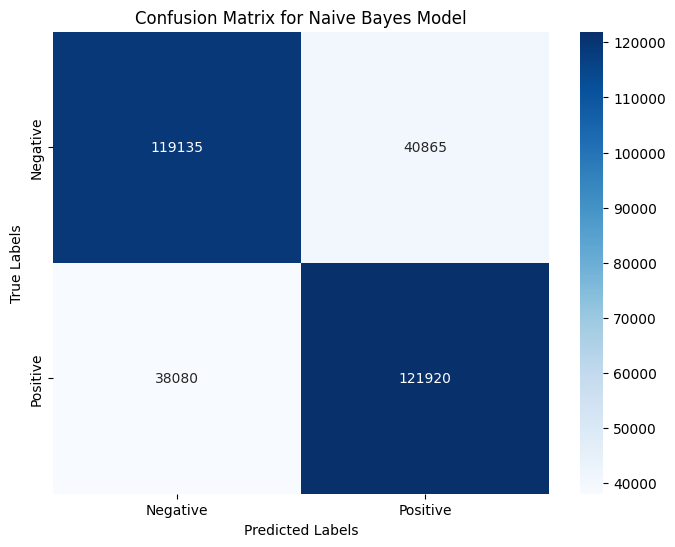

In [23]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_encoded, Y_pred_nb_encoded)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

Model Performance Comparison

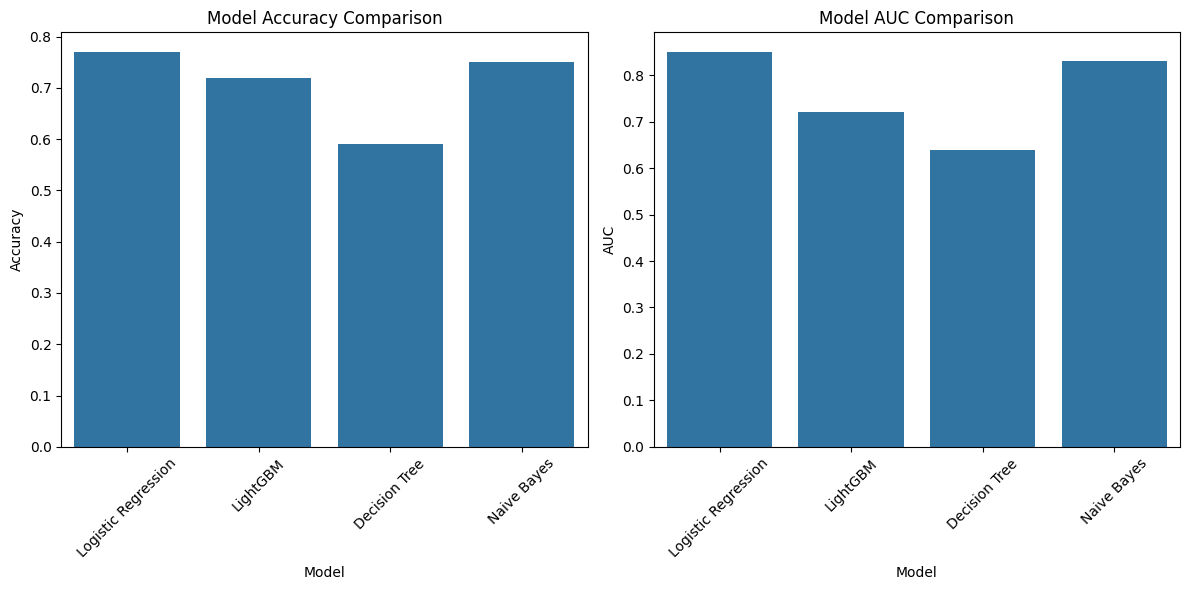

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example placeholder values for model results; replace with actual results
accuracy_lr = 0.77
accuracy_lgb = 0.72
accuracy_dt = 0.59
accuracy_nb = 0.75
auc_lr = 0.85
auc_lgb = 0.80
auc_dt = 0.64
auc_nb = 0.83

model_names = ['Logistic Regression', 'LightGBM', 'Decision Tree', 'Naive Bayes']
accuracy_scores = [accuracy_lr, accuracy_lgb, accuracy_dt, accuracy_nb]
auc_scores = [auc_lr, auc_lgb, auc_dt, auc_nb]

plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
sns.barplot(x=model_names, y=accuracy_scores)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# AUC
plt.subplot(1, 2, 2)
sns.barplot(x=model_names, y=auc_scores)
plt.title('Model AUC Comparison')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


HyperTunning

In [25]:
from sklearn.model_selection import GridSearchCV
# Define your logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=1)

# Set up the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization type
    'solver': ['liblinear']        # Solver that supports l1 penalty
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_vec, Y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Final evaluation on test set
best_model.fit(X_train_vec, Y_train)
Y_pred = best_model.predict(X_test_vec)

# Convert string labels to integers
encoder = LabelEncoder()
Y_test_encoded = encoder.fit_transform(Y_test)
Y_pred_encoded = encoder.transform(Y_pred)

# Calculate the AUC
print('Best Parameters:', grid_search.best_params_)
print('Logistic Regression Test Accuracy:', accuracy_score(Y_test_encoded, Y_pred_encoded))
print('Logistic Regression Test AUC:', roc_auc_score(Y_test_encoded, Y_pred_encoded))


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Test Accuracy: 0.768553125
Logistic Regression Test AUC: 0.768553125


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Initialize the logistic regression model with the best parameters
best_lr_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000, random_state=1)

# Fit the model on the training data
best_lr_model.fit(X_train_vec, Y_train)

# Predict on the test data
Y_pred = best_lr_model.predict(X_test_vec)

# Convert string labels to integers
encoder = LabelEncoder()
Y_test_encoded = encoder.fit_transform(Y_test)
Y_pred_encoded = encoder.transform(Y_pred)

# Calculate the AUC
print('Logistic Regression Test Accuracy:', accuracy_score(Y_test_encoded, Y_pred_encoded))
print('Logistic Regression Test AUC:', roc_auc_score(Y_test_encoded, Y_pred_encoded))


Logistic Regression Test Accuracy: 0.768553125
Logistic Regression Test AUC: 0.768553125


Making predctions

In [38]:
from sklearn.linear_model import LogisticRegression

# Assuming X_train_vec and Y_train are defined and correctly preprocessed
lr_model = LogisticRegression(max_iter=1000, random_state=1)
lr_model.fit(X_train_vec, Y_train)

# Check if the model has coefficients
print(lr_model.coef_)


[[-0.83732648 -0.06856302  0.21980653 ...  0.2419762   0.77086656
   0.2470161 ]]


In [39]:
import pickle

with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)


In [40]:
with open('logistic_regression_model.pkl', 'rb') as file:
    loaded_lr_model = pickle.load(file)

# Attempt to print the coefficients to confirm the model is loaded correctly
try:
    print("Coefficients:", loaded_lr_model.coef_)
except AttributeError as error:
    print("Failed to load the fitted model:", error)


Coefficients: [[-0.83732648 -0.06856302  0.21980653 ...  0.2419762   0.77086656
   0.2470161 ]]


In [43]:
# After fitting your encoder
print(loaded_encoder.classes_)


[0 1]


In [44]:
def preprocess_and_predict(new_text):
    # Vectorize the new text using the loaded vectorizer
    new_text_vectorized = loaded_vectorizer.transform([new_text])

    # Predict using the loaded model
    new_prediction = loaded_lr_model.predict(new_text_vectorized)

    # Decode prediction using the loaded encoder
    decoded_prediction = loaded_encoder.inverse_transform(new_prediction)

    return decoded_prediction[0]  # This will now return 'Negative' or 'Positive' instead of 0 or 1

# Example usage
sample_text = "This product has great features!"
print("Prediction:", preprocess_and_predict(sample_text))


Prediction: 1


In [45]:
def preprocess_and_predict(new_text):
    new_text_vectorized = loaded_vectorizer.transform([new_text])
    new_prediction = loaded_lr_model.predict(new_text_vectorized)

    # Directly map the prediction to 'Negative' or 'Positive'
    return "Positive" if new_prediction[0] == 1 else "Negative"

# Example usage
sample_text = "I love using my new phone; it's awesome!"
print("Prediction:", preprocess_and_predict(sample_text))


Prediction: Positive
